# Introduction to `pandora-sim`

`pandora-sim` is a simulator for Pandora data that is currently under development. 

In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import pandorasim as ps
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.time import Time
from tqdm import tqdm
from pandorasim.utils import plot_nirda_integrations

## Obtaining Target Information

Suppose we want to simulate Pandora observations of the system GJ 436 system. Let's first use the built-in `Target` class to obtain information our target.

The `Target` class will soon move to another package in the Pandora software ecosystem, so check back frequently for the most up-to-date syntax.

In [4]:
target = ps.Target.from_gaia("GJ 436")

We can see that our `target` object now contains a lot of useful information about the system, such as the Right Ascension, Declination, Effective Temperatureof the host star, orbiting planets, and more. 

In [5]:
target.ra

<Quantity 175.55287748 deg>

In [6]:
target.dec

<Quantity 26.70116594 deg>

In [7]:
target.teff

<Quantity 3228.1418 K>

In [8]:
target.jmag

6.9

In [9]:
target.bmag

10.893038

In [10]:
target.planets

{'b': {'pl_orbper': <Quantity 2.64388312 d>,
  'pl_tranmid': <Quantity 2454510.80162 d>,
  'pl_trandur': <Quantity 1.00536 h>,
  'pl_trandep': <Quantity 0.6819 %>}}

To make simulations you'll need targets with information about the SED. Our `target` object already has this and we can plot this information using

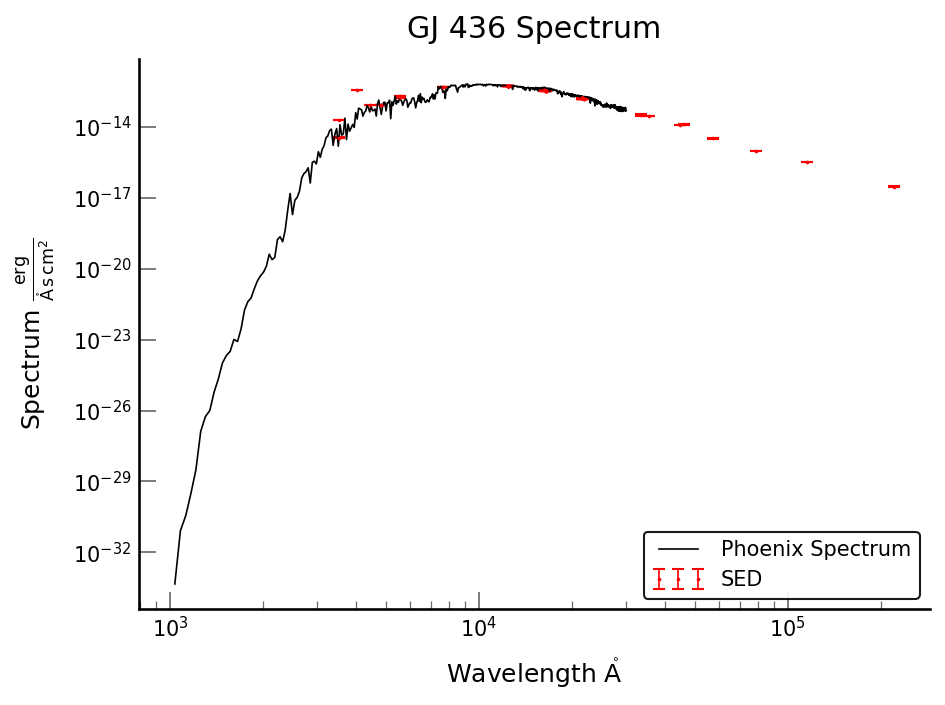

In [11]:
target.plot_spectrum();

We can also interpolate our spectrum to view it within a certain wavelength regime.

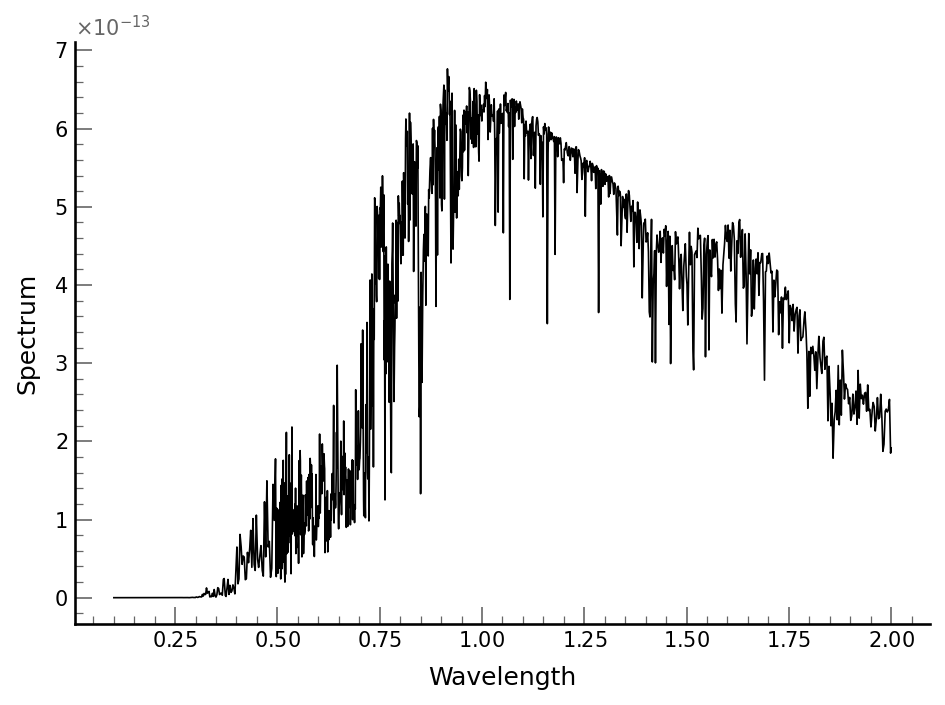

In [12]:
w = np.arange(0.1, 2, 0.0001) * u.micron
with plt.style.context(ps.PANDORASTYLE):
    fig, ax = plt.subplots()
    ax.plot(w, target.spectrum(w))
    ax.set(xlabel='Wavelength', ylabel='Spectrum')

It is also possible to access the SED with the `SED` property of our `target` object in order to manipulate it directly.

In [13]:
target.SED

{'wavelength': <Quantity [  3519.02124613,   3519.02124613,   3519.02124613,
              4020.01284613,   4442.02782634,   4819.96942024,
              4819.96942024,   5537.04925845,   5537.04925845,
              5537.04925845,   5537.04925845,   7634.91208679,
              7634.91208679,  12390.16606051,  12390.16606051,
             12390.16606051,  12390.16606051,  12390.16606051,
             12390.16606051,  12390.16606051,  12390.16606051,
             12390.16606051,  12500.20672977,  12500.20672977,
             12500.20672977,  16300.15539365,  16300.15539365,
             16494.77072902,  16494.77072902,  16494.77072902,
             16494.77072902,  16494.77072902,  16494.77072902,
             16494.77072902,  16494.77072902,  16494.77072902,
             21637.85333815,  21637.85333815,  21637.85333815,
             21637.85333815,  21637.85333815,  21637.85333815,
             21637.85333815,  21637.85333815,  21637.85333815,
             21637.85333815,  21900.24530

Our `target` class also allows us the ability to simulate what the transits of the planets contained in our system would look like. For now, we are restricted to using box-like transit shapes. In the future, however, this will be exanded to include the option to simulate more realistic transit shapes.

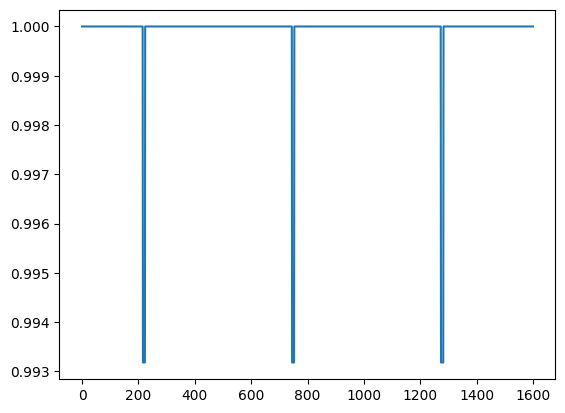

In [14]:
transit = target.box_transit(time=np.arange(0, 8, 0.005))
plt.plot(transit)

## Pandora Observatory

Now that we have information about our target, we can initialize the observatory using the `PandoraSim` class. The general workflow for using `pandora-sim` is as follows: point the observatory, set up some observations parameters, then obtain simulated output.

First, let's pick an observation duration and start time and set up the observatory. Note these are astropy quantities and times.

In [15]:
duration = 360*u.minute
obstime = Time(target.planets['b']['pl_tranmid'].value - (duration/2).to(u.day).value, format='jd')

Let's arbitrarily assume a roll angle of 10 degrees. Roll angle is dependent on the exact orbit which is not yet defined, so it's ok to arbitrarily choose for now. It's also possible to input any arbitrary RA, Dec, and roll angle here so it's not necessary to obtain the coordinates of a specific target using the `Target` class, but we're going to stick with the example of GJ 436.

In [16]:
p = ps.PandoraSim(ra=target.ra, dec=target.dec, theta=10*u.deg, duration=duration, obstime=obstime)

What is this doing?

* Setting up two subclasses to the observatory which are the NIRDA and VISDA
* Finding a catalog on sky at the correct location
* Applying a WCS with reasonable distortions to the catalog for each instrument


What is this NOT doing:

* Checking that your observation is possible (currently we have no information on the orbit of Pandora, so we can't tell if the observatory is behind the Earth). **We are not checking if there are timing constraints on this observation, or e.g. sun angle constraints.** For that you'll have to go to `pandora-scheduler` for now.

Now that we've set up the pointing of the observayory, let's plot the footprint of Pandora's VISDA and NIRDA detectors on our field of view with our target and background stars visible.

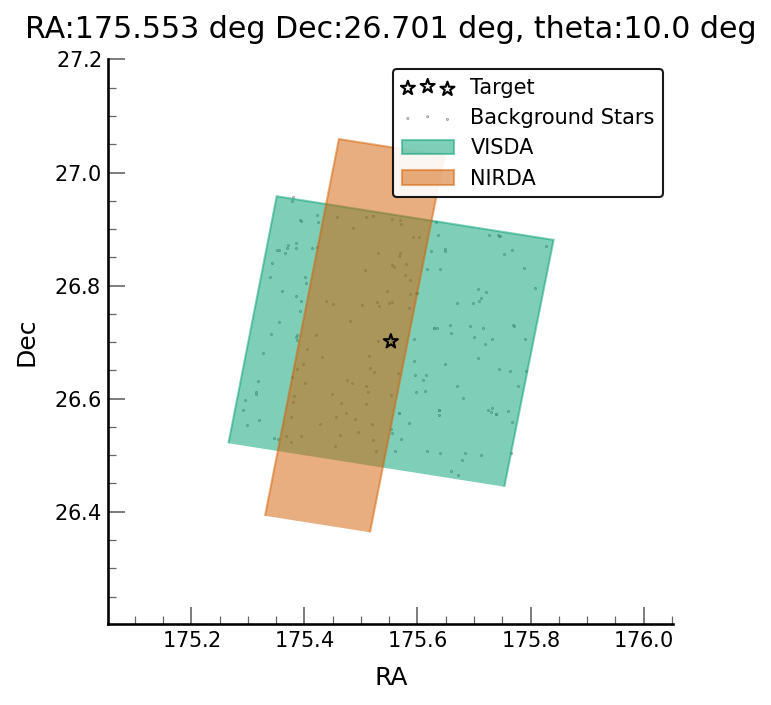

In [17]:
fig = p.plot_footprint();

We can break out the two detectors of the observatory individually if we want to access any of their specific functions more quickly.

In [18]:
nirda = p.NIRDA
visda = p.VISDA

## Basic Detector Properties

Since the NIRDA and VISDA classes in `pandora-sim` inherit all of the properties of their corresponding classes in `pandora-sat`, we can access all of the values contained in pandora-sat easily through `pansora-sim` using the same syntax.

We can start by checking the sensitivity of the two detectors.

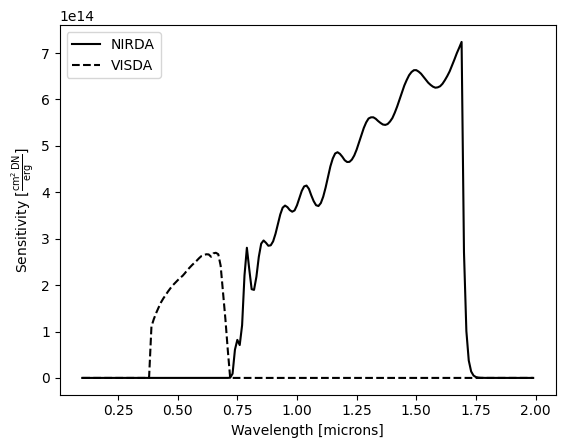

In [19]:
w = np.arange(0.1, 2, 0.01) * u.micron
fig, ax = plt.subplots()
ax.plot(w, nirda.sensitivity(w), label='NIRDA', c='k', ls='-')
ax.plot(w, visda.sensitivity(w), label='VISDA', c='k', ls='--')
ax.set(xlabel='Wavelength [microns]', ylabel=f"Sensitivity [{nirda.sensitivity(w).unit.to_string('latex')}]")
plt.legend()

We can also estimate the flux/magnitude of a source

In [20]:
nirda.flux_from_mag(10)

<Quantity 3.41062868e-14 erg / (Angstrom cm2 s)>

In [21]:
visda.flux_from_mag(10)

<Quantity 3.77670343e-13 erg / (Angstrom cm2 s)>

In [22]:
nirda.mag_from_flux(1e-15 * u.erg/(u.AA * u.s * u.cm**2))

<Quantity 13.8320861>

In [23]:
visda.mag_from_flux(1e-15 * u.erg/(u.AA * u.s * u.cm**2))

<Quantity 16.44278221>

Or access many of the pointing-independent properties of the detectors, including the dark current and the read noise, among other properties. See the `pandora-sat` documentation for a full list of accessible properties.

In [24]:
visda.dark

<Quantity 1. electron / s>

In [25]:
visda.read_noise

<Quantity 1.5 electron>

It's also possible for us to take a look at the PSFs and PRFs for each detector with the `diagnose` function. This functionality will likely change over time as the code is transferred over to the `pandora-psf` package, so check back frequently for updates.

Let's take a look at the PSFs and PRFs for NIRDA first

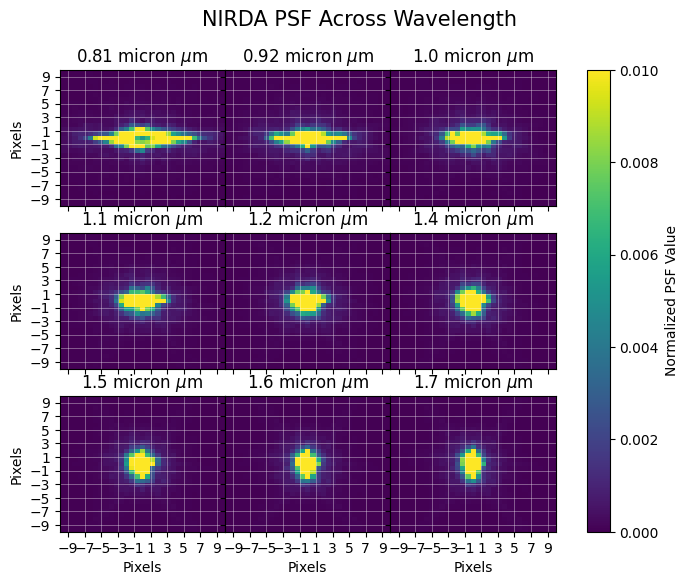

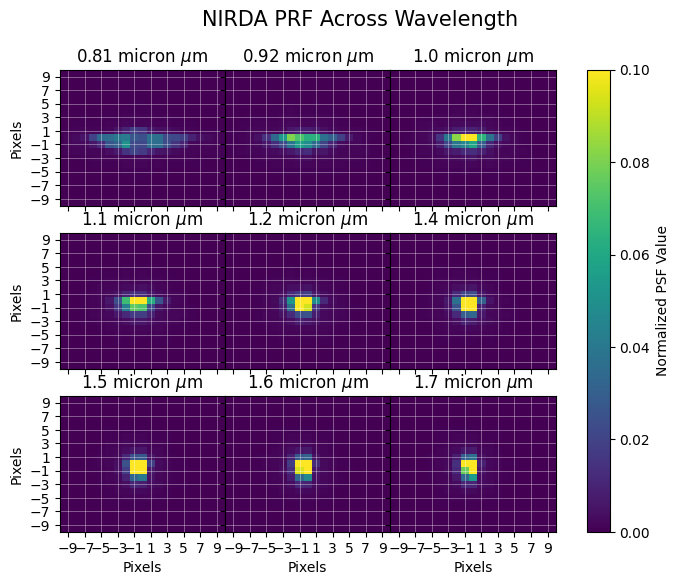

In [26]:
nirda.diagnose(n=3, image_type='psf');
nirda.diagnose(n=3, image_type='prf');

And now for VISDA

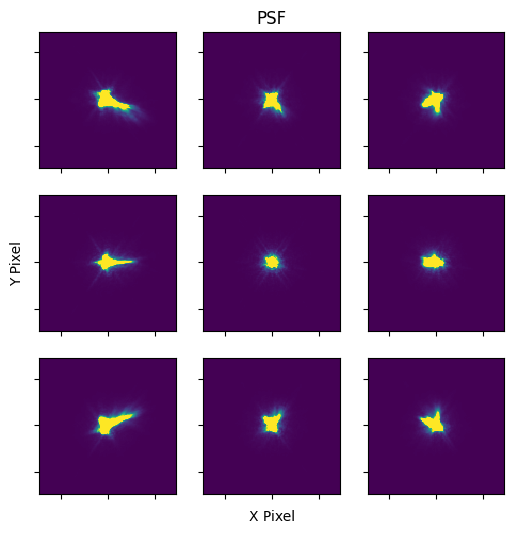

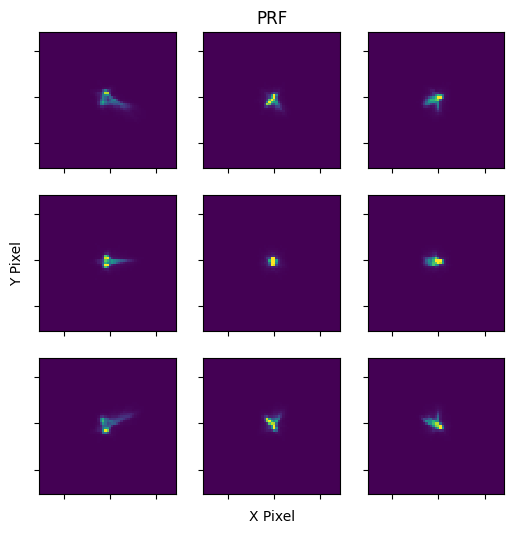

In [27]:
visda.diagnose(n=3, image_type='psf');
visda.diagnose(n=3, image_type='prf');

## Making Visible Image Simulations

Now that we have our observatory pointed and set up for observing, we can make some visible image simulations. To do this we need to get the sky catalog for the sky around our target. Luckily, our `PandoraSim` object queried Gaia DR3 within the bounds of the visible detector upon initialization. This is saved as the `SkyCatalog` property of our object. It is also possible to query the nearby field using the `get_sky_catalog` method to obtain a standalone source catalog.

In [28]:
p.SkyCatalog

,ra,dec,mag,vis_row,vis_column,nir_row,nir_column,vis_counts,vis_flux,jmag,teff,logg,ruwe,ang_sep
0,175.552877,26.701166,10.893038,1022.999849,1023.000000,1022.999945,79.000000,115501.968750,1.659196e-13,6.900,3228.141846,4.0089,1.125377,0.002658
1,175.530955,26.702659,15.576467,1013.983083,1113.213525,1017.026249,138.131586,1546.029907,2.220886e-15,13.654,4854.255859,4.4883,1.026066,0.019611
2,175.593817,26.704698,16.582132,1067.953363,859.593883,1052.244346,-28.112256,612.282104,8.795488e-16,15.038,5404.709473,4.4928,0.951376,0.036744
3,175.513437,26.674722,18.370363,874.084932,1161.985120,925.079444,170.093263,117.939484,1.694211e-16,15.535,3844.972412,4.8407,1.046657,0.044045
4,175.594439,26.666202,15.941728,893.154896,826.182509,937.467322,-50.000785,1104.367065,1.586433e-15,14.571,5580.291504,4.5011,1.051605,0.050910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,175.298995,26.552678,18.265965,145.100383,1936.287635,435.147156,678.040250,129.843048,1.865207e-16,13.880,3389.384521,4.8999,1.016730,0.271188
177,175.764798,26.503809,14.977934,256.097901,2.991693,507.656564,-590.108827,2683.063477,3.854245e-15,13.273,5228.775391,4.6086,1.104241,0.273576
178,175.377813,26.949021,18.195177,1999.307772,1932.358055,1649.921923,676.246796,138.590576,1.990866e-16,14.142,3429.619141,4.6629,1.046936,0.292906
179,175.380412,26.956778,18.350275,2035.517206,1928.032792,1673.216306,673.447210,120.141899,1.725849e-16,15.258,3821.009521,4.7834,1.077752,0.298326


In [29]:
len(p.SkyCatalog)

181

Now we have everything we need to make an image of the sky on the visible camera. We can use the `plot_FFI` method of our `PandoraSim` object to generate this image. In this method, we can specify whether we want to include simulated noise, simulated cosmic rays, the number of detector integrations coadded to make the frame, and whether to identify nearby single stars with the Pandora visible subarray projected onto them. 

The nearby stars identified are included in order of expected visible detector counts, selecting the target plus the eight brightest background targets. It's important to note that targets with a RUWE > 1.2 are not included.

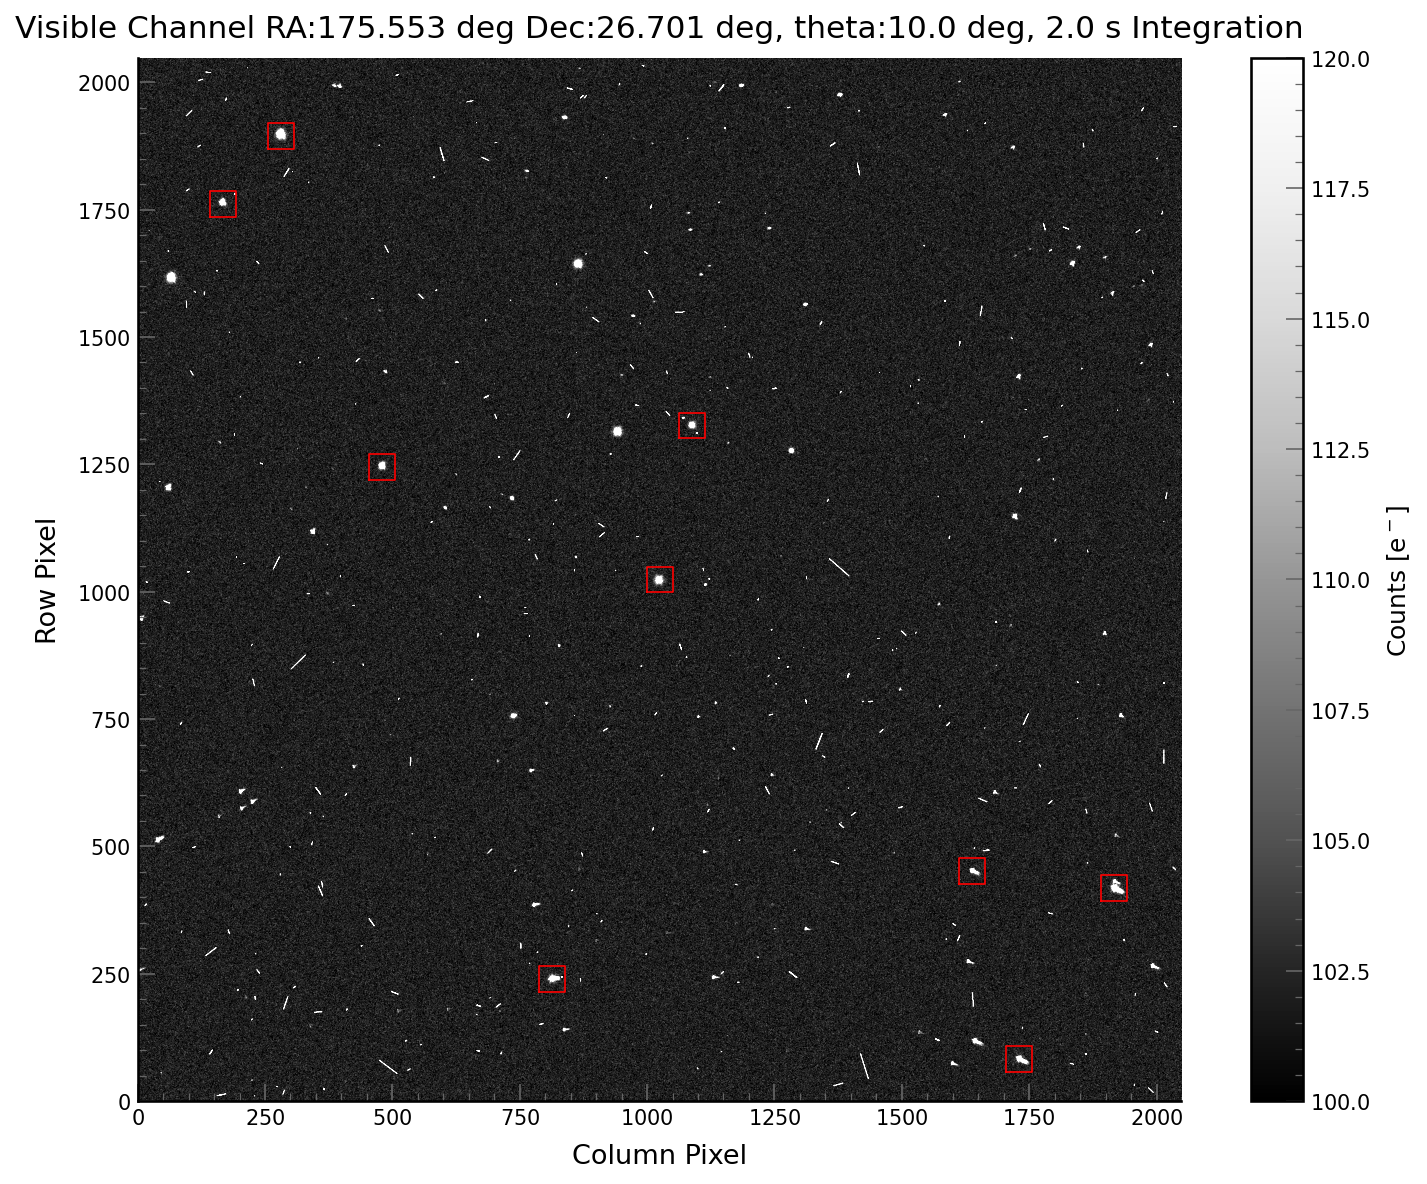

In [30]:
p.plot_FFI(nreads=10, include_noise=True, include_cosmics=True, subarrays=True);

We can see that our target GJ 436 is right in the center of the visible detector and the positions of a few nearby single Gaia stars are also framed within boxes representing Pandora's visible subarray. With this, we can plot the target pixel files (TPFs) for our target and some nearby bright stars.

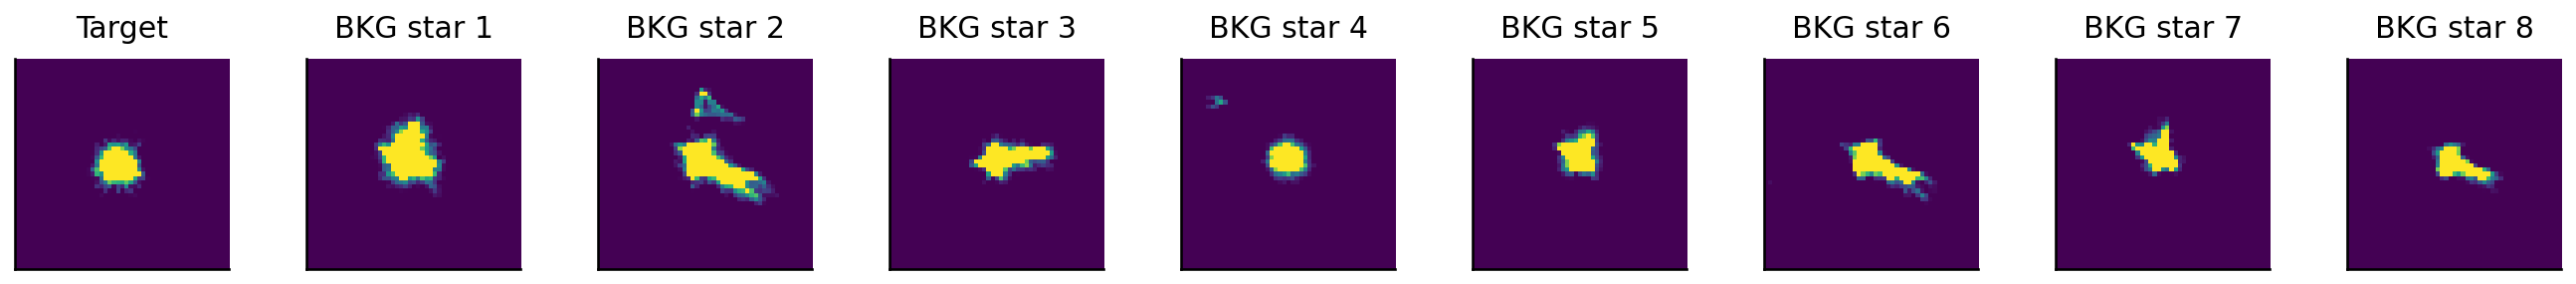

In [31]:
p.VISDA.plot_TPFs();

# Making realistic data simulations

We can turn our TPFs into simulated data as well. Let's select the TPF for our target and use the `get_target_timeseries` method to generate a time series for our observation.

In [32]:
time, flux = p.VISDA.get_target_timeseries(ts_func=target.box_transit, subarray=0)

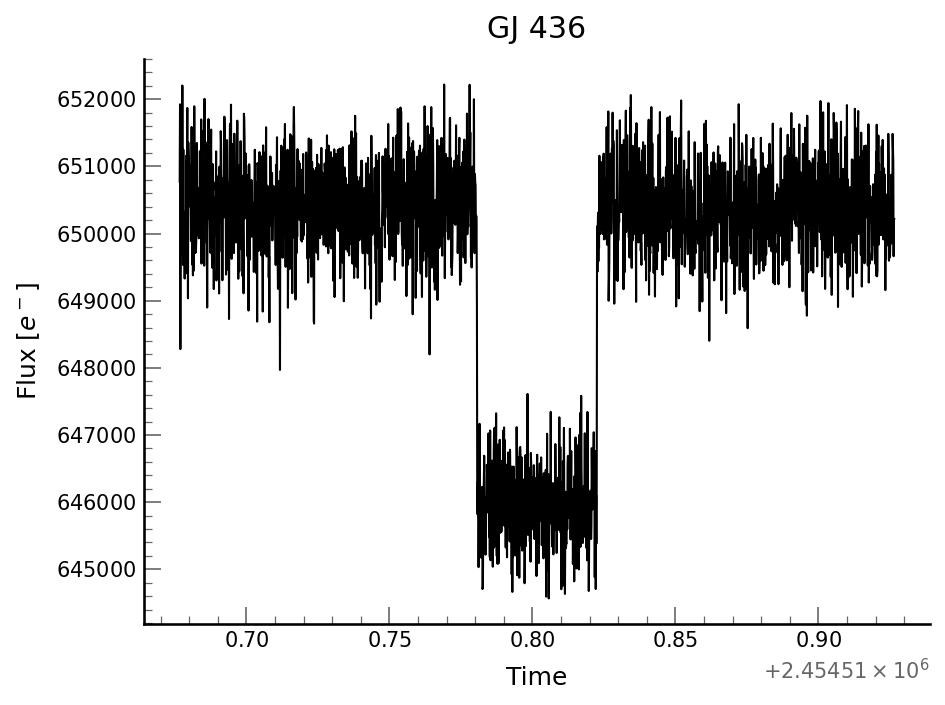

In [33]:
with plt.style.context(ps.PANDORASTYLE):
    fig, ax = plt.subplots()
    ax.plot(time, flux, c='k', lw=1)
    ax.set(xlabel='Time', ylabel='Flux [$e^-$]', title=target.name)

This is injecting the target flux at the pixel level in the PSF from LLNL, alongside background stars from the Gaia catalog with reasonable Pandora flux. We have reasonable noise estimates from what we know about the detector. (Note: these estimates will *update* so make sure to *update* `pandora-sim` frequently!)

This does **not** currently have expected jitter in it, but will include this soon. Adding jitter drastically slows down the simulation so some clever thinking is necessary.

## Getting a NIRDA Trace

Here we're using "trace" to mean the spectrum dispersed onto the detector. This has some thickness to it.

To make a NIRDA trace we're going to use this fast trace function. This is definitely going to change, and will be wrapped up in a nice function in the future.

In [34]:
wav_edges, fasttrace = p.NIRDA.get_fasttrace(sub_res=9, npix=2)

Building fasttrace:   0%|          | 0/9 [00:00<?, ?it/s]

Building fasttrace: 100%|██████████| 9/9 [01:52<00:00, 12.52s/it]


We need to know where the source falls on the detector, this function will include expected distortions

In [35]:
row, col = p.NIRDA.world_to_pixel(p.ra, p.dec)[:, 0]

We need to integrate the spectrum across the sensitivity, and calculate the integrated spectrum at each wavelength element

In [36]:
integral = p.NIRDA.get_integrated_spectrum(w, target.spectrum(w), wav_edges, plot=True)

Then we can calculate the "trace" at that point

In [37]:
r, c, prf = fasttrace(row, col)
trace = (integral[:, None, None] * prf).sum(axis=0)

If we plot the integral compared with the trace, we see that the PSF blurs out the features in wavelength.

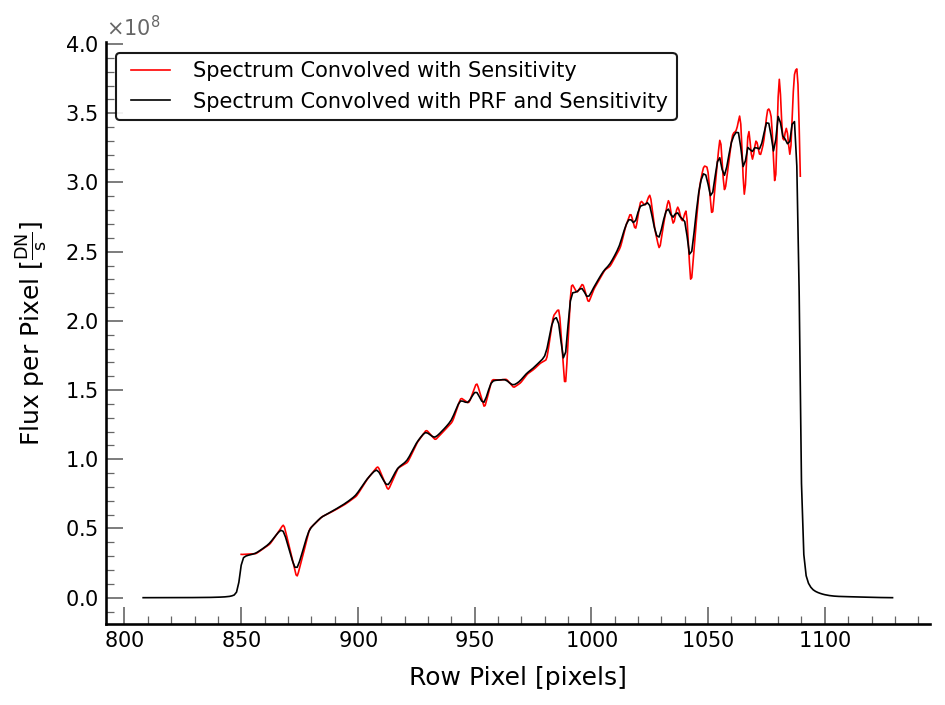

In [38]:
npix = 2
with plt.style.context(ps.PANDORASTYLE):
    fig, ax = plt.subplots()
    w1 = p.NIRDA.wavelength_to_pixel(wav_edges.mean(axis=1) * u.micron).value + row
    ax.plot(w1, integral * npix, label='Spectrum Convolved with Sensitivity', c='r')
    ax.plot(r, trace.sum(axis=1), c='k', label='Spectrum Convolved with PRF and Sensitivity')
    ax.set(xlabel=f"Row Pixel [pixels]", ylabel=f"Flux per Pixel [{integral.unit.to_string('latex')}]")
    ax.legend(frameon=True)

Here we can see the trace as an image

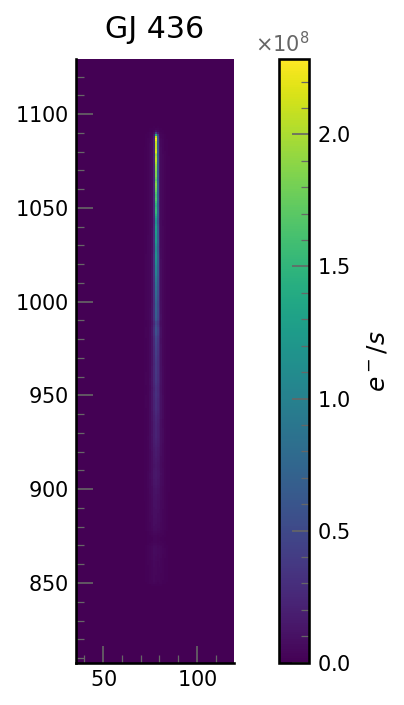

In [39]:
with plt.style.context(ps.PANDORASTYLE):
    fig, ax = plt.subplots()
    plt.pcolormesh(c, r, trace.value, cmap='viridis')
    plt.gca().set_aspect('equal')
    cbar = plt.colorbar()
    cbar.set_label('$e^-/s$')
    ax.set(title=f'{target.name}')

However we need to include extra targets from the background.

In [40]:
from pandorasim.utils import get_phoenix_model

In [41]:
integrals = []
for idx, c in tqdm(p.NIRDA.Catalog.iterrows(), total=len(p.NIRDA.Catalog), desc='Calculating Star Integrals'):
    w, s = get_phoenix_model(teff=c.teff if np.isfinite(c.teff) else 5777, 
                             logg=c.logg if np.isfinite(c.logg) else 4.5,
                             jmag=c.jmag)
    integrals.append(p.NIRDA.get_integrated_spectrum(w, s, wav_edges, plot=True) * p.NIRDA.frame_time)

Calculating Star Integrals:   0%|          | 0/5 [00:00<?, ?it/s]

Calculating Star Integrals: 100%|██████████| 5/5 [00:00<00:00,  6.97it/s]


In [42]:
corner = p.NIRDA.subarray_corner
size = p.NIRDA.subarray_size
R, C = p.NIRDA.subarray_row, p.NIRDA.subarray_column
s = np.zeros(p.NIRDA.subarray_size)
cat = p.NIRDA.Catalog
for i, r1, c1 in zip(integrals, np.asarray(cat.nir_row), np.asarray(cat.nir_column)):
    r, c, prf = fasttrace(r1, c1)
    subtrace = (i[:, None, None] * prf).sum(axis=0)
    ok1 = (((r - corner[0]) >= 0) & ((r - corner[0]) < size[0]))[:, None] & ((c - corner[1]) >= 0) & ((c - corner[1]) < size[1])
    ok2 = np.in1d(R[:, 0],  r)[:, None] & np.in1d(C[0],  c) 
    s[ok2] += subtrace.value[ok1]
s = p.NIRDA.apply_gain(s*u.DN)

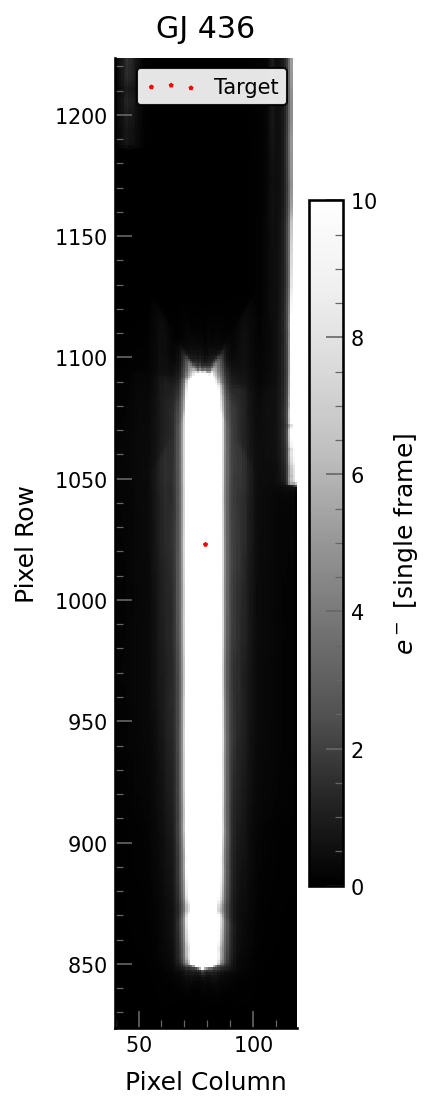

In [43]:
with plt.style.context(ps.PANDORASTYLE):
    fig, ax = plt.subplots(figsize=(3, 1.5 * np.divide(*p.NIRDA.subarray_size)))
    im = ax.pcolormesh(p.NIRDA.subarray_column, p.NIRDA.subarray_row, s, vmin=0, vmax=10, cmap='Greys_r')
    ax.scatter(*p.NIRDA.world_to_pixel(p.NIRDA.ra, p.NIRDA.dec).T[0][::-1], c='r', marker='*', label='Target')
    ax.legend(frameon=True)
    ax.set(xlabel='Pixel Column', ylabel='Pixel Row',title=target.name)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('$e^-$ [single frame]')

And there's the NIRDA trace of our target!

We can also plot a simulated NIRDA integration scheme using the `utils.plot_nirda_integrations` function. Let's specify a few values and plot up an integration scheme for ourselves.

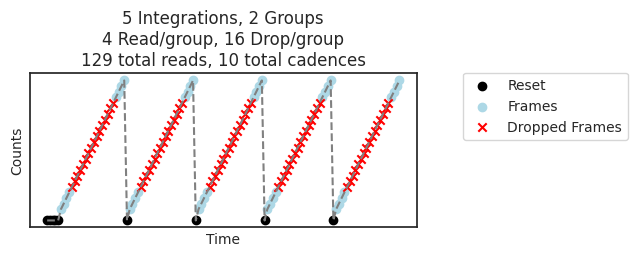

In [44]:
SC_Resets1 = 5
SC_Resets2 = 1
SC_DropFrames1 = 0
SC_DropFrames2 = 16
SC_DropFrames3 = 0
SC_ReadFrames = 4
SC_Groups = 2
SC_Integrations = 5

plot_nirda_integrations(
    SC_Resets1,
    SC_Resets2,
    SC_DropFrames1,
    SC_DropFrames2,
    SC_DropFrames3,
    SC_ReadFrames,
    SC_Groups,
    SC_Integrations,
);